# Readability Assessment through Recurrent Neural Network

Readability assessment is a well known problem in natural language processing field. Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. In this notebook we are trying to assess the readability of a given text regardless of the text subject using recurrent neural network.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [157]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional
# from tensorflow.keras.engine.input_layer import Input

import numpy as np

# glove = load_glove_embeddings()
corpus = load_corpus()
articles, tags = corpus_to_words(corpus)

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [158]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles[i][:words])], 
        ["Intermediate",detokenize(articles[i+2][:words])], 
        ["Elementary",detokenize(articles[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 10px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [159]:
maxlen = 1000 # Cuts off reviews after 100 words
training_samples = 450
validation_samples = 117
max_words = 45
articles, tags = corpus_to_pos(corpus)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles)
print(tokenizer.word_index)
print(len(tokenizer.word_index))


{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}
44


In [160]:
sequences = tokenizer.texts_to_sequences(articles)
# print(sequences)
print(np.shape(sequences))


(567,)


In [161]:

data = pad_sequences(sequences, maxlen=maxlen)
print(data)
print(np.shape(data))

[[ 0  0  0 ...  2 17  8]
 [ 0  0  0 ...  2 17  8]
 [ 0  0  0 ...  2 17  8]
 ...
 [ 0  0  0 ...  4  1  8]
 [ 0  0  0 ...  4  1  8]
 [ 0  0  0 ...  4  1  8]]
(567, 1000)


In [162]:
print(np.shape(tags))
labels = to_categorical(tags)
print(np.shape(labels))

(567,)
(567, 3)


In [163]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print(np.shape(data), np.shape(labels), np.shape(data[0]))

x_train= data[:training_samples]
y_train= labels[:training_samples]
print(np.shape(x_train), np.shape(y_train))

x_val =data[training_samples:]
y_val =labels[training_samples:]
print(np.shape(x_val), np.shape(y_val))
from tensorflow.python import keras


(567, 1000) (567, 3) (1000,)
(450, 1000) (450, 3)
(117, 1000) (117, 3)


In [166]:
data = data.reshape(data.shape[0], data.shape[1], 1)
# labels = labels.reshape(labels.shape[0], labels.shape[1], 1)
# print(data.shape)
# print(labels.shape)
model = Sequential()
# model.add(Embedding(45, embedding_dim, input_length=maxlen))
# model.add(Flatten(input_shape=(1000,)))
model.add(LSTM(100, input_shape=(1000,1)))
# model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 303       
Total params: 41,103
Trainable params: 41,103
Non-trainable params: 0
_________________________________________________________________


In [167]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='acc',patience=10, verbose=1, mode='auto')

model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit(data, labels,
epochs=10,
validation_split=0.2)
model.save_weights('pre_trained_glove_model.h5')


Train on 453 samples, validate on 114 samples
Epoch 1/10
453/453 [==============================] - 20s 44ms/step - loss: 1.1111 - acc: 0.3289 - val_loss: 1.1228 - val_acc: 0.2982
Epoch 2/10
453/453 [==============================] - 17s 39ms/step - loss: 1.1046 - acc: 0.3488 - val_loss: 1.0994 - val_acc: 0.3860
Epoch 3/10
453/453 [==============================] - 18s 39ms/step - loss: 1.1025 - acc: 0.3488 - val_loss: 1.1154 - val_acc: 0.2895
Epoch 4/10
453/453 [==============================] - 18s 39ms/step - loss: 1.0998 - acc: 0.3510 - val_loss: 1.1037 - val_acc: 0.3333
Epoch 5/10
453/453 [==============================] - 18s 39ms/step - loss: 1.0990 - acc: 0.3532 - val_loss: 1.1223 - val_acc: 0.2895
Epoch 6/10
453/453 [==============================] - 18s 39ms/step - loss: 1.0990 - acc: 0.3731 - val_loss: 1.1119 - val_acc: 0.2719
Epoch 7/10
453/453 [==============================] - 18s 39ms/step - loss: 1.0981 - acc: 0.3377 - val_loss: 1.1185 - val_acc: 0.3070
Epoch 8/10
453/4

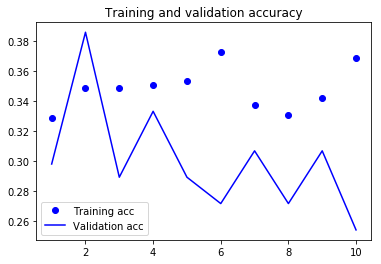

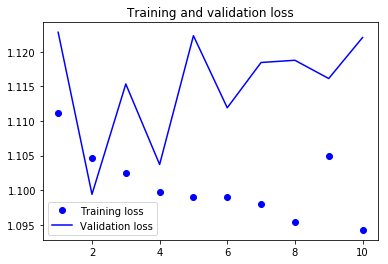

In [168]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


